
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [361]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [362]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()


In [363]:
# My includes
k_blue ='#19647E'

# Some code to build a status bar
from IPython.display import clear_output

def updateStatusBar(progress):
    bar_length = 40
    progress = float(progress)
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(bar_length * progress)

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.


**1.3** Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.

Plot two histograms ofyour best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.

Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.


**1.4** Using your top gene from the previous part (call it  `best_predictor`), create a classification model by manually eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.

<hr> <hr>

<hr>
### Solutions

**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [364]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)


X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [365]:

print(df.shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))


(752, 7130)
((601, 7129), (151, 7129), (601L,), (151L,))
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set (show a glimpse of what you did): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.**


In [366]:
#your code here
display(X_train.head(5))

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,-83.669345,-129.202197,91.188553,-132.634919,-416.659258,-566.248620,-549.255222,-208.415176,213.331881,-135.518811,...,111.849800,371.083898,252.006568,963.153393,9.955941,142.181944,442.730023,42.848269,512.106908,4.677488
604,-65.718571,-302.842019,-297.819728,-177.485917,-52.709137,-218.295750,195.983474,-268.235930,-328.630912,240.058672,...,252.867110,110.033722,203.197907,101.612259,-138.398658,245.767616,247.519122,-15.430358,-398.165984,-61.694246
341,-264.191248,-162.255274,127.997172,173.771779,-185.191211,40.011778,-1562.983106,-85.344926,-119.622143,219.619110,...,20.797496,-184.115075,-227.872398,140.876523,42.543763,28.594281,204.479474,9.831559,21.718266,19.522122
117,-92.558574,-109.788332,379.542547,391.641129,-184.507364,-577.178389,-293.421369,-372.534572,190.551199,-487.331438,...,180.678776,577.889184,-50.443125,417.586154,-11.190519,1478.997020,15.923333,112.986515,-107.706335,-25.673203
516,-143.099813,140.202023,-147.163850,222.339115,-231.007621,-753.616356,274.500343,-217.513332,-107.135509,-62.470938,...,139.821329,909.588696,43.531613,718.462679,-58.238405,232.494165,754.787059,-58.160474,1808.764690,-20.782346


In [367]:
X_train_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)

display(X_train_n.head(5))

X_test_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,...,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,...,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,...,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,...,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,...,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a data set? Explain in 3 or fewer sentences.**

More predictors than observations can lead to overfitting of the model. Without regularization, t-tests, statistical significance estimates, or other analysis of the coeficients, the logistic regression will always be able to achieve 100% accuracy on the training model. This will result in a poor result when run on the test set.

**1.3** **Identify and report which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the data set).  Note: it wil lbe useful to save this list for future parts.**

**Plot two histograms of your best predictor - one using training and another for the testing dataset. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint: You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.**

'Top Gene Expression: '

'M31523_at'

Top 10 genes based on t-test:
M31523_at
X95735_at
M84526_at
X61587_at
U50136_rna1_at
X17042_at
U29175_at
Y08612_at
Z11793_at
X76648_at


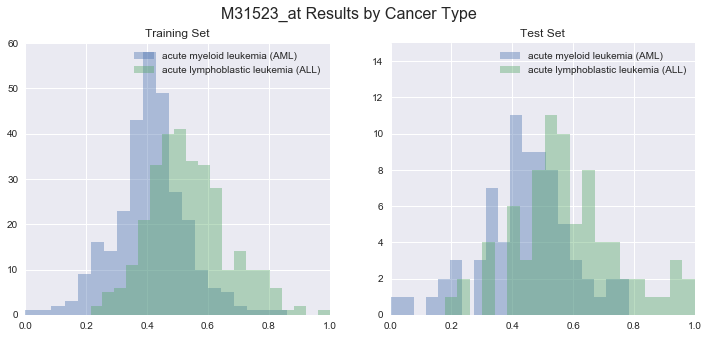

In [368]:
# Split into datasets that contain only AML and only ALL values
X_train_AML = X_train_n.loc[y_train == 1.0]
X_train_ALL = X_train_n.loc[y_train == 0.0]

assert (X_train_AML.size + X_train_ALL.size == X_train_n.size)

# Run t-test, sort array, reverse array, and grab top 10 classifiers
relevant_genes = np.argsort(np.abs(X_train_AML.mean() - X_train_ALL.mean()) / \
    np.sqrt(X_train_AML.var()/X_train_AML.shape[0] + X_train_ALL.var()/X_train_ALL.shape[0]))[::-1][0:10]

best_predictor = X_train_n.columns[relevant_genes.iloc[0]]

display('Top Gene Expression: ', best_predictor)

print("Top 10 genes based on t-test:")
print('\n'.join([X_train_n.columns[col] for col in relevant_genes]))

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle(best_predictor + ' Results by Cancer Type', fontsize=16)

axes[0].hist(X_train_AML[best_predictor], bins=20, alpha=0.4, label='acute myeloid leukemia (AML)')
axes[0].hist(X_train_ALL[best_predictor], bins=20, alpha=0.4, label='acute lymphoblastic leukemia (ALL)')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlim((0,1))
axes[0].set_ylim((0,60))
axes[0].set_title('Training Set')

X_test_AML = X_test_n.loc[y_test == 1.0]
X_test_ALL = X_test_n.loc[y_test == 0.0]

axes[1].hist(X_test_AML[best_predictor], bins=20, alpha=0.4, label='acute myeloid leukemia (AML)')
axes[1].hist(X_test_ALL[best_predictor], bins=20, alpha=0.4, label='acute lymphoblastic leukemia (ALL)')
axes[1].grid(True)
axes[1].legend()
axes[1].set_xlim((0,1))
axes[1].set_ylim((0,15))
axes[1].set_title('Test Set')

plt.show()

**1.4 Using your top gene from the previous part (call it  `best_predictor`), create a classification model by eye-balling a value for this gene that would discriminate the two classes the best. Justify your choice in 1-2 sentences. Report the accuracy of this hand-chosen model on the test set.**


In [369]:
best_predictor = X_train_n.columns[relevant_genes.iloc[0]]

# Take the average between the two means to set as our threshold
threshold = np.mean([X_train_AML[best_predictor].mean(), X_train_ALL[best_predictor].mean()])

cancer_type_predict = X_train_n[best_predictor] < threshold
accuracy_train = (cancer_type_predict == y_train).mean()

accuracy_test = ((X_test_n[best_predictor] < threshold) == y_test).mean()

print("Using gene expression, {}, with a threshold of {:.3}, we correctly predict cancer type with accuracy of {:2.3}%"
      .format(best_predictor, threshold, accuracy_test*100))

Using gene expression, M31523_at, with a threshold of 0.474, we correctly predict cancer type with accuracy of 68.9%


I took the midpoint between the means of the two classes as the threshold to split the result

<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>


In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor that you identify as the best predictor above to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?


Create a figure with following items displayed on the same plot (use training data):
 - the predicted quantitative response from the linear regression model as a function of the best gene predictor
 - the true binary response. 


**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret the logistic regression coefficients: the 'slope' and intercept. 


Create 2 plots (one each for training and testing data) with 4 items displayed on each plot.
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>
### Solutions

**2.1** **Fit a simple linear regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. The scores predicted by the regression model for a patient could be interpreted as an estimate of the probability that the patient has Cancer_type=1 (AML).  Is there a problem with this interpretation?**



In [370]:
import statsmodels.api as sm
from statsmodels.api import OLS

# your code here
OLSModel = sm.OLS(y_train.values, sm.add_constant(X_train_n[best_predictor]))
OLSModel_Fit = OLSModel.fit()

display(OLSModel_Fit.params)
display(OLSModel_Fit.rsquared)

const        1.260137
M31523_at   -1.623278
dtype: float64

0.20711999168180639

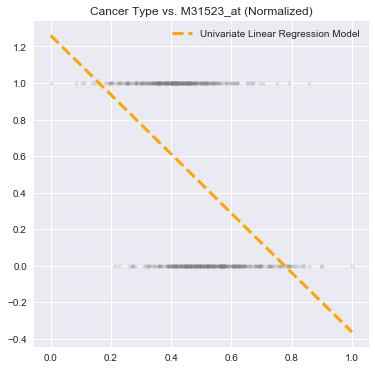

In [371]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

x = np.linspace(min(X_train_n[best_predictor]), max(X_train_n[best_predictor]), 100)
y = OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*x

axes.scatter(X_train_n[best_predictor], y_train.values, color='grey', marker='.', alpha=0.2)
axes.plot(x, y, color='orange', ls='--', linewidth=3, label='Univariate Linear Regression Model')
axes.set_title('Cancer Type vs. ' + best_predictor + ' (Normalized)')
axes.grid(True)
axes.legend()

One problem with using a linear model for classification is that it does not approach 0 or 1 at the extremes. In fact, it's possible to get values above and below 0 and 1 for some values of x.

**2.2** **Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes' classifier.  Evaluate the classification accuracy of this classification model on both the training and test sets.**

In [386]:
accuracy_test = accuracy_score(((OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*X_test_n[best_predictor]) > 0.5), y_test)

print("Using gene expression, {}, with linear model y = {:0.2} + {:0.2}*x, we predict cancer type with accuracy of {:2.3}%"
      .format(best_predictor, OLSModel_Fit.params[0], OLSModel_Fit.params[1], accuracy_test*100))

Using gene expression, M31523_at, with linear model y = 1.3 + -1.6*x, we predict cancer type with accuracy of 68.2%



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [373]:
lr = LogisticRegression(C=100000, solver='liblinear')
lr.fit(sm.add_constant(X_train_n[best_predictor]), y_train)
y_hat_test = lr.predict(sm.add_constant(X_test_n[best_predictor]))
cur_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using only best predictor from t-test')
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))
print('Coefficients:', lr.coef_[0])

Using only best predictor from t-test
Training Accuracy: 83.5%
Test Accuracy: 86.0%
('Coefficients:', array([ 2.03863637, -8.75711199]))


The classifications are actually almost exactly the same. The only difference is that the logistic model tapers off towards each extreme, as the sigmoid function will only approach 0 and 1.


**2.4 Print and interpret the logistic regression coefficients: the 'slope' and the intercept.**

**Create 2 plots (with training and test data) with 4 items displayed on each plot.**
- the predicted quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$.

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.** 


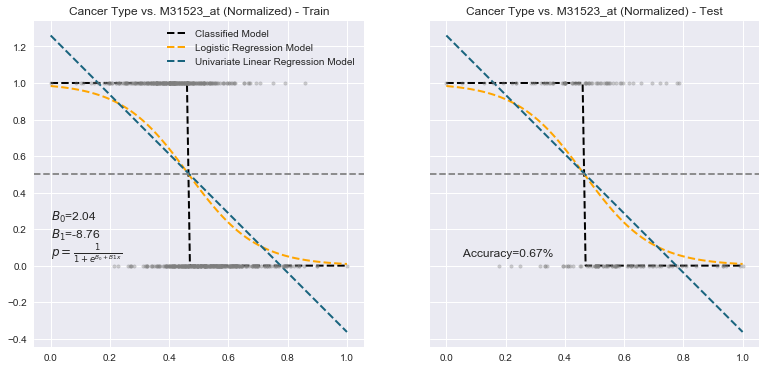

In [296]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)

x = np.linspace(0, 1, 101)
#y = 1/(1+np.exp(-(x*lr.coef_[0][1] + lr.coef_[0][0])))
y = OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*x

# Plot 
axes[0].plot(x, lr.predict(sm.add_constant(x)), color='black', ls='--', linewidth=2, label='Classified Model')
axes[0].scatter(X_train_n[best_predictor], y_train.values, color='grey', marker='.', alpha=0.4, zorder=20)
axes[0].plot(x, lr.predict_proba(sm.add_constant(x))[:,1], color='orange', ls='--', linewidth=2, label='Logistic Regression Model')
axes[0].plot(x, y, color='#19647E', ls='--', linewidth=2, label='Univariate Linear Regression Model')
axes[0].axhline(y=0.5, ls='--', color='gray')
axes[0].set_title('Cancer Type vs. ' + best_predictor + ' (Normalized) - Train')
axes[0].grid(True)
axes[0].legend()
axes[0].text(0, 0.25, r"""$B_0$={:1.2f}""".format(lr.coef_[0][0]))
axes[0].text(0, 0.15, r"""$B_1$={:1.2f}""".format(lr.coef_[0][1]))
axes[0].text(0, 0.05, r"""$p=\frac{1}{1 + e^{B_0 + B1x}}$""")

axes[1].plot(x, lr.predict(sm.add_constant(x)), color='black', ls='--', linewidth=2, label='Classified Model')
axes[1].scatter(X_test_n[best_predictor], y_test.values, color='grey', marker='.', alpha=0.4, zorder=20)
axes[1].plot(x, lr.predict_proba(sm.add_constant(x))[:,1], color='orange', ls='--', linewidth=2, label='Logistic Regression Model')
axes[1].plot(x, y, color='#19647E', ls='--', linewidth=2, label='Univariate Linear Regression Model')
axes[1].axhline(y=0.5, ls='--', color='gray')
axes[1].set_title('Cancer Type vs. ' + best_predictor + ' (Normalized) - Test')
axes[1].grid(True)
axes[1].text(0, 0.05, r"""     Accuracy={:1.2f}%""".format(cur_accuracy))
plt.show()

Over the range of data we have seen, both of the models seem to fit the data equivilently. More importantly, both of the models are fairly poor at predicting. The models would be better if category was more correlated with the single gene expression we have selected, in which case we would see that the logistic classifier would have more resonable probability rates at the extremes.

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of training and test set? Given the results above how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole? 

**3.4** Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1** **Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [297]:
lr = LogisticRegression(C=100000, solver='liblinear')
lr.fit(sm.add_constant(X_train_n), y_train)

y_hat_train = lr.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using all predictors from model')
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))
print('Coefficients:', lr.coef_[0])

Using all predictors from model
Training Accuracy: 100.0%
Test Accuracy: 76.16%
('Coefficients:', array([-0.00869259,  0.62361236,  0.16003856, ..., -0.14957648,
        0.36888304,  0.31650229]))


The accuracy for this model increases from 67% to 76%. However, on our training data we have an accuracy of 100%. This indicates that the model is highly over-fit, because a. We can not have 100% accuracy in this case, and b. The accuracy on the training set is MUCH higher than the test set.

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** **To answer this question, use *bootstrapping* with 1000 bootstrap samples/iterations.**  


In [315]:
np.random.seed(None)

samples = 1000
alpha = 0.05

x_vals = len(X_train.columns)

updateStatusBar(0)
slopes = np.zeros((samples, x_vals + 1))
for i in range(samples):
    X, X_bs, y, y_bs = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = None, 
                                                         stratify = df.Cancer_type)
    
    #X_bs = df_bs.drop('Cancer_type', axis=1)
    #y_bs = df_bs['Cancer_type']
    
    X_bs_n = \
        pd.DataFrame(MinMaxScaler().fit_transform(X_bs.values), columns=X_bs.columns, index=X_bs.index)
    
    # Update timing status
    updateStatusBar(float(i)/samples)
    
    # Perfrorm logistic regression on new sample
    lr = LogisticRegression(C=100000, solver='liblinear')
    lr.fit(sm.add_constant(X_bs_n), y_bs)
    
    # Save slope
    slopes[i] = lr.coef_
updateStatusBar(1)

Progress: [########################################] 100.0%


[ 0.892  0.588  0.334 ...,  0.296  0.866  0.667]

27 predictors significant at 5.0% level at indices:
[ 411  429  773 1709 1778 1881 2241 2287 2736 3251 3319 3558 4115 4341 4365
 4406 4672 4846 4950 5106 5650 5744 5983 6040 6214 6377 6841]


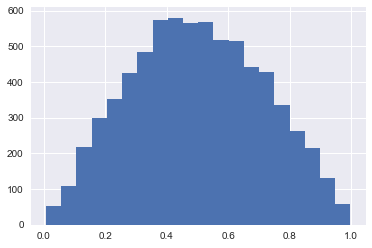

In [298]:
# For each predictor, calculat the percentage of positive coefficients from bootstrapping
p_values = np.zeros(x_vals)
for x in range(1,x_vals + 1):
    p_values[x-1] = float(len([num for num in slopes[:,x] if num > 0]))/len(slopes[:,x])
print(p_values)

stat_sig = np.argwhere((p_values<=alpha/2) | (p_values>=(1-alpha/2))).T[0]
print('\n{} predictors significant at {:1.2}% level at indices:'.format(len(stat_sig), alpha*100))
print(stat_sig)
plt.hist(p_values,bins=20)
plt.title = 'p-value distribution'
plt.show()

###### **3.3 Open question: Comment on the classification accuracy of training and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole.**

The training and test set are far over-fitting the data by included data that is not statistically significant. I would remove the values that don't meet a significance level of 0.05. By removing these we are actually able to get a higher R-squared value and a drastically simpler model.

**3.4 Now use regularization to improve predictions from the multiple logistic regression model.  Use LASSO-like regularization and cross-validation within the training set to tune the model.  Report the classification accuracy on both the training and test set.**

In [299]:
# Run logistic regression using LASSO-like regularization
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(sm.add_constant(X_train_n), y_train)

y_hat_train = lr.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using penalty \'l1\' on logistic regression. {0} coefficients remaining of {1}'.format(
    np.count_nonzero(lr.coef_[0]),len(lr.coef_[0])))
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))

Using penalty 'l1' on logistic regression. 171 coefficients remaining of 7130
Training Accuracy: 95.34%
Test Accuracy: 78.81%


In [300]:
print('Relevant Genes (t-test):', relevant_genes.values)
print('Cross with LASSO Reg:', np.isin(relevant_genes.values + 1, np.where(lr.coef_[0] != 0)))
print(np.where(lr.coef_[0] != 0)[0] - 1)

('Relevant Genes (t-test):', array([6854, 4846, 2287, 4365, 3319, 4195, 7118, 4972, 5053, 4581], dtype=int64))
('Cross with LASSO Reg:', array([ True, False, False,  True,  True, False, False, False,  True, False], dtype=bool))
[  21  140  239  250  310  330  353  366  391  433  582  672  674  707  719
  726  773  815  843  871  896  898  941 1000 1034 1073 1111 1119 1126 1170
 1247 1250 1271 1290 1304 1363 1428 1490 1516 1664 1709 1744 1772 1778 1788
 1869 1881 1883 1923 1927 2005 2181 2211 2219 2241 2247 2264 2307 2354 2393
 2407 2409 2442 2447 2494 2555 2556 2596 2609 2698 2738 2748 2768 2840 2847
 2885 2923 2990 3098 3216 3251 3254 3268 3312 3317 3319 3360 3428 3481 3485
 3558 3713 3789 3875 3897 3918 3951 4018 4097 4127 4194 4212 4235 4246 4283
 4316 4328 4341 4356 4365 4366 4370 4374 4398 4406 4430 4479 4498 4508 4525
 4543 4573 4621 4672 4698 4701 4759 4776 4881 4931 4950 4974 5017 5053 5076
 5152 5230 5253 5273 5289 5291 5353 5404 5413 5551 5553 5588 5737 5744 5765
 5777 5800 5

**3.5: Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [301]:
print('Number of "top 10" predictors that show up in LASSO regularized model: {}'.format(
    np.sum(np.isin(relevant_genes.values + 1, np.where(lr.coef_[0] != 0)))))

Number of "top 10" predictors that show up in LASSO regularized model: 4


In [302]:
print('Number of "top 10" predictors that show up in significantly significant list: {}'.format(
    np.sum(np.isin(relevant_genes.values, stat_sig))))

Number of "top 10" predictors that show up in significantly significant list: 4


In [303]:
# Run logistic regression using only statistically significant values
lr = LogisticRegression(C=100000, solver='liblinear')
lr.fit(sm.add_constant(X_train_n.iloc[:,stat_sig]), y_train)

y_hat_train = lr.predict(sm.add_constant(X_train_n.iloc[:,stat_sig]))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr.predict(sm.add_constant(X_test_n.iloc[:,stat_sig]))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Using only statistically significant predictors at {:1.2}% level'.format(alpha*100))
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))
print('Coefficients:', lr.coef_[0])

Using only statistically significant predictors at 5.0% level
Training Accuracy: 88.52%
Test Accuracy: 78.15%
('Coefficients:', array([-7.53189885, -1.40738949, -1.45936476,  1.21051707,  4.13826921,
        4.90112589,  1.1531866 ,  4.485058  ,  2.18754627,  1.41939067,
        1.9049529 ,  1.8803405 , -2.68198974,  0.1860353 , -2.72382733,
        1.91152532,  1.54988073, -1.953047  ,  2.684556  ,  1.84850248,
        2.06422148,  2.45181223,  0.52559839, -4.07627814, -0.15953652,
        2.75731691,  6.35784143,  2.85771351]))


The top 10 predictors we found using the t-test above do tend to show up in the both the statistically significant value list from bootstrapping and in the LASSO-like regularization model. There is not a perfect overlap, with only 4 of our top 10 genes being relevant in the LASSO-like model. However, since the LASSO model does achieve an accuracy of 79% using 179 predictors and our model using top 10 predictors from the t-test achieves only 70%, we can assume that the t-test includes some false-positive predictors. 

<div class='exercise'> <b> Question 4 [25pts]: Multi Class Log Regression </b> </div>

**4.1** Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using the training dataset.  It should be easily discernable via labeling/marking in the plot which observations belong to which `cancer_type`.

**4.3** Fit the following two models using crossvalidation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundaries for each model and interpret the results. Hint: You may utilize the function `overlay_decision_boundary`. 

**4.5** Report and plot the CV scores for the two models and interpret. 


<hr>
### Solutions

**4.1 Load the data from `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [305]:
df = pd.read_csv('data/hw4_mc_enhance.csv', index_col=0)

In [306]:
print('Count of unique classified values {}: {}'.format(np.unique(df.cancer_type),len(np.unique(df.cancer_type))))

Count of unique classified values [ 0.  1.  2.]: 3


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [307]:
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'cancer_type'], 
                                                        df.cancer_type, test_size=0.2, 
                                                        random_state = 8,
                                                        stratify = df.cancer_type)

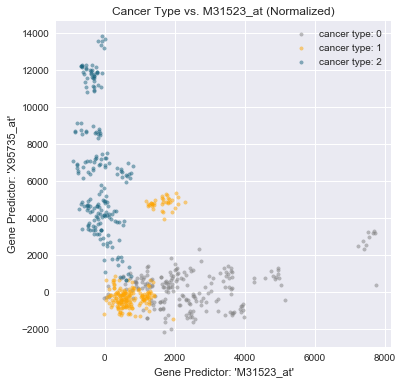

In [308]:
# Plot cancer_type vs 'M31523_at', 'X95735_at'
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

x = np.linspace(min(X_train_n[best_predictor]), max(X_train_n[best_predictor]), 100)
y = OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*x

axes.scatter(X_train.loc[y_train == 0.0]['M31523_at'], X_train.loc[y_train == 0.0]['X95735_at'],
             color='grey', marker='.', alpha=0.5, label='cancer type: 0')
axes.scatter(X_train.loc[y_train == 1.0]['M31523_at'], X_train.loc[y_train == 1.0]['X95735_at'],
             color='orange', marker='.', alpha=0.5, label='cancer type: 1')
axes.scatter(X_train.loc[y_train == 2.0]['M31523_at'], X_train.loc[y_train == 2.0]['X95735_at'],
             color=k_blue, marker='.', alpha=0.5, label='cancer type: 2')
axes.set_title('Cancer Type vs. ' + best_predictor + ' (Normalized)')
axes.set_xlabel('Gene Predictor: \'M31523_at\'')
axes.set_ylabel('Gene Predictor: \'X95735_at\'')
axes.grid(True)
axes.legend()

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [309]:
# Normalize Data
X_train_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)[['M31523_at','X95735_at']]

display(X_train_n.head(5))

X_test_n = \
    pd.DataFrame(MinMaxScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)[['M31523_at','X95735_at']]

# Run logistic regression using only statistically significant values
Cs = 10.0**np.arange(-5,5)

lr_CV = LogisticRegressionCV(Cs = Cs, cv=5, solver='liblinear', penalty='l1')

lr_CV.fit(sm.add_constant(X_train_n), y_train)

y_hat_train = lr_CV.predict(sm.add_constant(X_train_n))
train_accuracy = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr_CV.predict(sm.add_constant(X_test_n))
test_accuracy = accuracy_score(y_test.values, y_hat_test)

print('Running lr_CV for [\'M31523_at\',\'X95735_at\']'.format(alpha*100))
print('Training Accuracy: {:.4}%'.format(train_accuracy*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy*100))
print('Coefficients:', lr_CV.coef_[0])

,M31523_at,X95735_at
243,0.250313,0.130529
414,0.075462,0.594172
527,0.185473,0.087111
187,0.267711,0.436474
117,0.525084,0.202885


Running lr_CV for ['M31523_at','X95735_at']
Training Accuracy: 83.5%
Test Accuracy: 86.0%
('Coefficients:', array([ -1.53686082,  19.44104028,  -7.0346347 ]))


In [310]:
def add_poly_terms(df, cols='all', N=2):
    df = df.copy()
    
    if cols == 'all':
        cols = df.columns
    for p in range(2, N+1):
        for col in cols:
            df['{}^{}'.format(col, p)] = df[col]**p
    return df

In [311]:
# Add polynomial terms
X_train_n_poly = add_poly_terms(X_train_n, N=2)
X_train_n_poly['M31523_at*X95735_at'] = X_train_n['M31523_at']*X_train_n['X95735_at']
X_test_n_poly = add_poly_terms(X_test_n, N=2)
X_test_n_poly['M31523_at*X95735_at'] = X_test_n['M31523_at']*X_test_n['X95735_at']

display(X_train_n_poly.head(5))

# Repeat for polynomial terms
Cs = 10.0**np.arange(-5,5)

lr_CV_p = LogisticRegressionCV(Cs = Cs, cv=5, solver='liblinear', penalty='l1')

lr_CV_p.fit(sm.add_constant(X_train_n_poly), y_train)

y_hat_train = lr_CV_p.predict(sm.add_constant(X_train_n_poly))
train_accuracy_p = accuracy_score(y_train.values, y_hat_train)
y_hat_test = lr_CV_p.predict(sm.add_constant(X_test_n_poly))
test_accuracy_p = accuracy_score(y_test.values, y_hat_test)

print('Running lr_CV with polynomial degree = 2 for [\'M31523_at\',\'X95735_at\']'.format(alpha*100))
print('Training Accuracy: {:.4}%'.format(train_accuracy_p*100))
print('Test Accuracy: {:.4}%'.format(test_accuracy_p*100))
print('Coefficients:', lr_CV_p.coef_[0])

,M31523_at,X95735_at,M31523_at^2,X95735_at^2,M31523_at*X95735_at
243,0.250313,0.130529,0.062657,0.017038,0.032673
414,0.075462,0.594172,0.005694,0.353040,0.044837
527,0.185473,0.087111,0.034400,0.007588,0.016157
187,0.267711,0.436474,0.071669,0.190510,0.116849
117,0.525084,0.202885,0.275713,0.041162,0.106532


Running lr_CV with polynomial degree = 2 for ['M31523_at','X95735_at']
Training Accuracy: 91.83%
Test Accuracy: 91.33%
('Coefficients:', array([  -1.94226234,  -59.55140132,   67.12646267,  222.08483022,
       -167.26372292,  -24.71593011]))


**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [314]:
def overlay_decision_boundary(ax, model, degrees=1, interaction=False, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    if degrees == 2:
        if interaction == False:
            X = np.c_[xx.flatten(), yy.flatten(), xx.flatten()**2, yy.flatten()**2]
        else:
            X = np.c_[xx.flatten(), yy.flatten(), xx.flatten()**2, yy.flatten()**2, xx.flatten()*yy.flatten()]
    else:
        if interaction == False:
            X = np.c_[xx.flatten(), yy.flatten()]
        else:
            X = np.c_[xx.flatten(), yy.flatten(), xx.flatten()*yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(sm.add_constant(X))
    #print("Do I predict" , y)
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, "Color not specified for predictions {}.".format(missing_colors)

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1, alpha=0.15)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=0.5, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

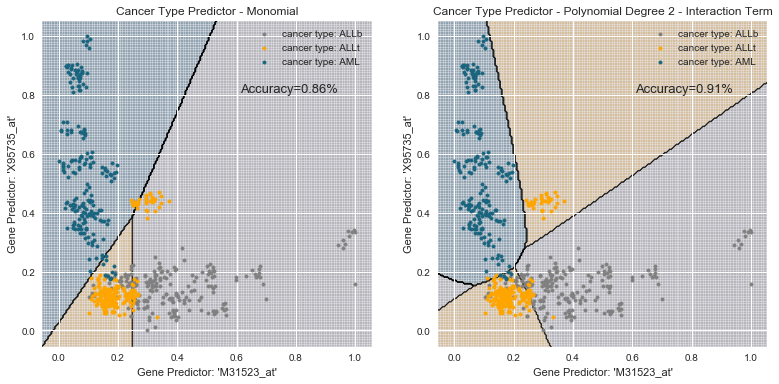

In [315]:
# Plot cancer_type vs 'M31523_at', 'X95735_at'
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

x = np.linspace(min(X_train_n[best_predictor]), max(X_train_n[best_predictor]), 100)
y = OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*x

axes[0].scatter(X_train_n.loc[y_train == 0.0]['M31523_at'], X_train_n.loc[y_train == 0.0]['X95735_at'],
             color='grey', marker='.', label='cancer type: ALLb')
axes[0].scatter(X_train_n.loc[y_train == 1.0]['M31523_at'], X_train_n.loc[y_train == 1.0]['X95735_at'],
             color='orange', marker='.', label='cancer type: ALLt')
axes[0].scatter(X_train_n.loc[y_train == 2.0]['M31523_at'], X_train_n.loc[y_train == 2.0]['X95735_at'],
             color=k_blue, marker='.', label='cancer type: AML')
overlay_decision_boundary(axes[0], lr_CV, colors=['grey','orange',k_blue])
axes[0].set_title('Cancer Type Predictor - Monomial')
axes[0].set_xlabel('Gene Predictor: \'M31523_at\'')
axes[0].set_ylabel('Gene Predictor: \'X95735_at\'')
axes[0].grid(True)
axes[0].text(0.61, 0.81, r"""Accuracy={:1.2f}%""".format(test_accuracy), fontsize=13)
axes[0].legend()

axes[1].scatter(X_train_n.loc[y_train == 0.0]['M31523_at'], X_train_n.loc[y_train == 0.0]['X95735_at'],
             color='grey', marker='.', label='cancer type: ALLb')
axes[1].scatter(X_train_n.loc[y_train == 1.0]['M31523_at'], X_train_n.loc[y_train == 1.0]['X95735_at'],
             color='orange', marker='.', label='cancer type: ALLt')
axes[1].scatter(X_train_n.loc[y_train == 2.0]['M31523_at'], X_train_n.loc[y_train == 2.0]['X95735_at'],
             color=k_blue, marker='.', label='cancer type: AML')
overlay_decision_boundary(axes[1], lr_CV_p, degrees=2, interaction=True, colors=['grey','orange',k_blue])
axes[1].set_title('Cancer Type Predictor - Polynomial Degree 2 - Interaction Term')
axes[1].set_xlabel('Gene Predictor: \'M31523_at\'')
axes[1].set_ylabel('Gene Predictor: \'X95735_at\'')
axes[1].grid(True)
axes[1].text(0.61, 0.81, r"""Accuracy={:1.2f}%""".format(test_accuracy_p), fontsize=13)
axes[1].legend()
plt.show()

**4.5 Report and plot the CV scores for the two models and interpret.**

In [316]:
# your code here
lr_CV.scores_

{0.0: array([[ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.85833333,
          0.925     ,  0.91666667,  0.91666667,  0.91666667,  0.91666667],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.84166667,
          0.9       ,  0.90833333,  0.90833333,  0.90833333,  0.90833333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.85833333,
          0.90833333,  0.89166667,  0.88333333,  0.88333333,  0.88333333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.86666667,
          0.9       ,  0.89166667,  0.9       ,  0.9       ,  0.9       ],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.80833333,
          0.925     ,  0.90833333,  0.90833333,  0.90833333,  0.90833333]]),
 1.0: array([[ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.85      ,  0.85      ,  0.85      ,  0.85      ,  0.85      ],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.85      

In [317]:
# your code here
lr_CV_p.scores_

{0.0: array([[ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.85833333,
          0.925     ,  0.90833333,  0.94166667,  0.93333333,  0.93333333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.84166667,
          0.9       ,  0.90833333,  0.90833333,  0.90833333,  0.90833333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.85833333,
          0.90833333,  0.86666667,  0.875     ,  0.875     ,  0.875     ],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.86666667,
          0.9       ,  0.925     ,  0.93333333,  0.93333333,  0.93333333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.80833333,
          0.925     ,  0.93333333,  0.94166667,  0.95      ,  0.95      ]]),
 1.0: array([[ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.85      ,  0.90833333,  0.94166667,  0.94166667,  0.93333333],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.8       

In each case we see the scores for permutation of class, Cs terms (regularization strength), and cv terms (each fold).
In both cases the highest score is achieved in the third class, the highest fold, and the highest regularization strength

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost.  How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the test set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.  Note that this needs to be evaluated on the patients in the test set.**
**
...
**

We can use the `predict_proba` function built in the model to get the probability of correctness for each classification. If the classification probability is less than a certain threshold, we will abstain classification. In this case, it costs `$`5000 to misdiagnose and $1000 to abstain. We should only abstain if `(1-p)*`$`5000 > $1000`.

In [318]:
percent_wrong = 1-test_accuracy
cost_mis = 5000
avg_cost = cost_mis*percent_wrong
print('Average cost per patient is ${:.5}, with misdiagnosis rate of {:.3}%'.format(avg_cost, percent_wrong*100))

Average cost per patient is $700.0, with misdiagnosis rate of 14.0%


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.**

In [319]:
threshold = 0.6
class_probs = lr_CV.predict_proba(sm.add_constant(X_test_n))
y_hat_test_abs = np.zeros(len(y_test.values))
for i in range(len(y_test.values)):
    if np.max(class_probs[i] >= threshold):
        y_hat_test_abs[i] = np.argmax(class_probs[i])
    else:
        y_hat_test_abs[i] = 4

percent_wrong = 1-accuracy_score(y_test.values, y_hat_test_abs)
abstain_count = np.sum(y_hat_test_abs == 4)
percent_abstain = float(abstain_count)/len(y_hat_test_abs)

avg_cost = (percent_wrong - percent_abstain)*cost_mis + percent_abstain*1000

print('The average cost using a probability threshold of {:.3} is ${:.5} -- {:.3}% misdiagnosed -- {:.3}% abstained'.format(
    threshold, avg_cost, 100*(percent_wrong- percent_abstain), 100*percent_abstain))

The average cost using a probability threshold of 0.6 is $440.0 -- 6.0% misdiagnosed -- 14.0% abstained
